In [1]:
#If the distribution skewness of one feature is more than 0.5, do log_transform.
# Imports
import numpy as np
from scipy.stats import skew
import scipy.stats as stats
from scipy.stats import skew
import matplotlib.pyplot as plt



import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from IPython.display import display

from xgboost import XGBRegressor

import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression


import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
data=pd.read_csv('Apply_Rate_2019.csv');
print('shape of data'+ str(data.shape) );
print(data.columns)
print(data.describe() )
print( data.head() )

shape of data(1200890, 10)
Index(['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score', 'city_match',
       'job_age_days', 'apply', 'search_date_pacific', 'class_id'],
      dtype='object')
       title_proximity_tfidf  description_proximity_tfidf  main_query_tfidf  \
count          948319.000000                948319.000000      1.200890e+06   
mean                5.889800                     0.096119      1.770301e+00   
std                 9.749672                     0.284249      2.237259e+00   
min                 0.000000                     0.000000      0.000000e+00   
25%                 0.000000                     0.000000      0.000000e+00   
50%                 0.000000                     0.000000      2.509947e-01   
75%                11.642839                     0.063633      3.423265e+00   
max                93.516720                     7.301161      1.774189e+01   

       query_jl_score  query

In [3]:
# Extract the train and test data from the dataset.
train_date=['2018-01-'+str(i) for i in range(21, 27, 1)]
test_date=['2018-01-'+str(i) for i in range(27, 28, 1)]
train_data=pd.DataFrame();
for date in train_date:
    temp= data.loc[ data['search_date_pacific']==date , :].copy();
    train_data=pd.concat([train_data, temp])
    
test_data=pd.DataFrame();
for date in test_date:
    temp= data.loc[ data['search_date_pacific']==date , :].copy();
    test_data=pd.concat([test_data, temp])

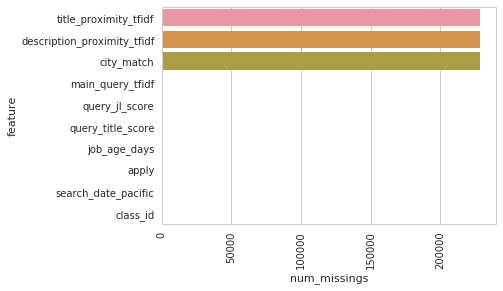

There is no missing data.


In [4]:
#1. Check missing Data in train_data and test_data. 
missing=pd.DataFrame();
missing['num_missings']= train_data.isnull().sum();
#missing= missing[ missing['num_missings']>0 ];
missing.sort_values('num_missings', ascending=False, inplace=True);
missing['feature']= missing.index;
sns.barplot(data= missing, y='feature', x='num_missings', orient='h')
plt.xticks(rotation=90)
plt.show()
print("There is no missing data.")


In [5]:
#1.Missing data: since we have enough dataset and we don't know what the NaN means in the dataset, we just drop these NaN.
train_data=train_data.dropna( axis=0);
test_data=test_data.dropna(axis=0);
data_total=pd.concat([train_data, test_data] );

In [6]:
data_total.tail()

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,city_match,job_age_days,apply,search_date_pacific,class_id
1200669,0.000000,0.0,0.000000,0.008090,0.007781,0.0,4.0,0,2018-01-27,2029928808769267768
1200735,0.000000,0.0,0.000000,0.009742,0.010149,0.0,16.0,0,2018-01-27,-547059124907035633
1200788,24.430948,0.0,5.292390,0.032044,0.300148,0.0,15.0,0,2018-01-27,-461013632408289405
1200831,0.000000,0.0,0.000000,0.016179,0.018877,1.0,2.0,0,2018-01-27,-7613806991329176388
1200864,0.000000,0.0,1.951831,0.019438,0.029351,1.0,5.0,0,2018-01-27,-4530023448177795385


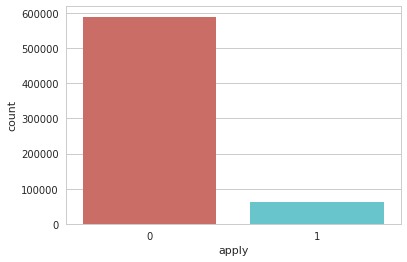

percentage of no subscription is 90.6165568837428
percentage of subscription 9.383443116257197
Our classes are imbalanced, and the ratio of no-subscription to subscription instances is 91:9. But before we go ahead to balance the classes, Let's do some more exploration.


In [7]:
#2.1. Data analysis: unitary data analysis
target='apply';
sns.countplot(x=target,data=train_data, palette='hls')
plt.show()

#Our classes are imbalanced, and the ratio of no-subscription to subscription instances is 89:11. We need to balance the classes. 
count_no_apply = len(train_data[train_data[target]==0])
count_apply = len(train_data[train_data[target]==1])
pct_of_no_apply = count_no_apply/(count_no_apply+count_apply)
print("percentage of no subscription is", pct_of_no_apply*100)
pct_of_apply = count_apply/(count_no_apply+count_apply)
print("percentage of subscription", pct_of_apply*100)

print("Our classes are imbalanced, and the ratio of no-subscription to subscription instances is 91:9. But before we go ahead to balance the classes, Let's do some more exploration.")

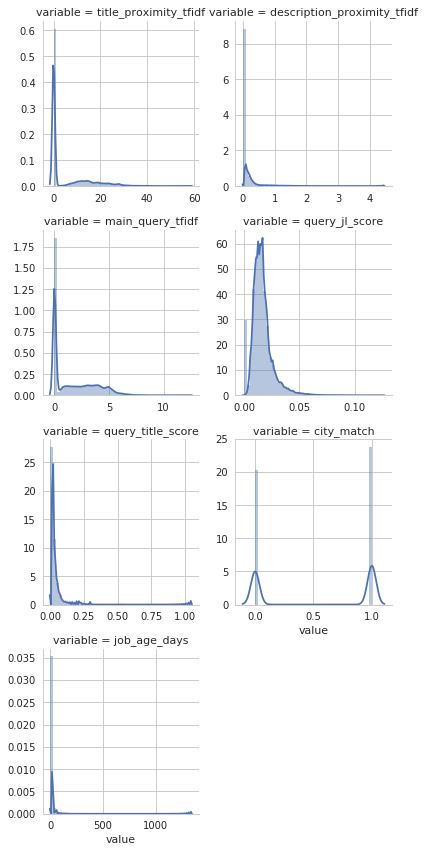

city_match is a binary distribution. All other features follow a peaked and skewed distribution with a long tail.


In [8]:
features_numeric=[col for col in train_data.columns if col not in ['search_date_pacific','apply','class_id']]  
f = pd.melt(train_data, value_vars=features_numeric)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
plt.show()


print("city_match is a binary distribution. All other features follow a peaked and skewed distribution with a long tail.")


In [9]:
train_data.groupby(target).mean()

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,city_match,job_age_days,class_id
apply,,,,,,,,
0,4.908829,0.087452,1.682489,0.015524,0.030921,0.539437,10.767649,-532315587717609792
1,6.119049,0.084807,1.910840,0.016613,0.037319,0.544304,10.025010,-556163761336013504


In [10]:
print("Generally speaking, if the user made an application, then there was a higher title_proximity_tfidf, a higher main_euery_tfidf, a higher query_ji_score, a higher query_title_score, a higher city_match, a lower job_age_days. However, apply is related to lower description_proximity_tfidf, that is really confusing.")


Generally speaking, if the user made an application, then there was a higher title_proximity_tfidf, a higher main_euery_tfidf, a higher query_ji_score, a higher query_title_score, a higher city_match, a lower job_age_days. However, apply is related to lower description_proximity_tfidf, that is really confusing.


In [11]:
train_data.groupby('city_match').mean()

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,job_age_days,apply,class_id
city_match,,,,,,,,
0.0,5.579223,0.090092,1.843379,0.015835,0.033754,10.578811,0.092935,-5.148889e+17
1.0,4.547847,0.084742,1.585063,0.015448,0.029619,10.799509,0.094601,-5.513118e+17


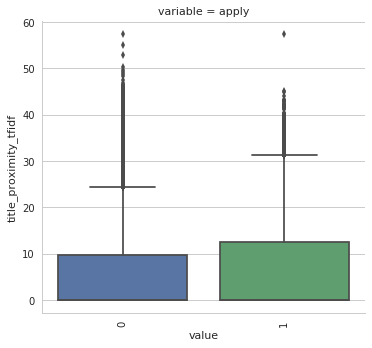

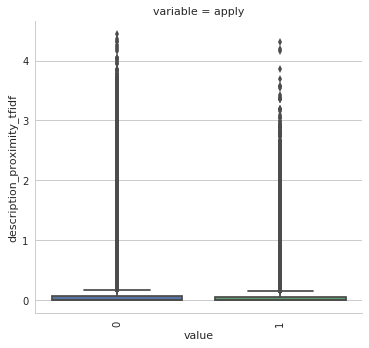

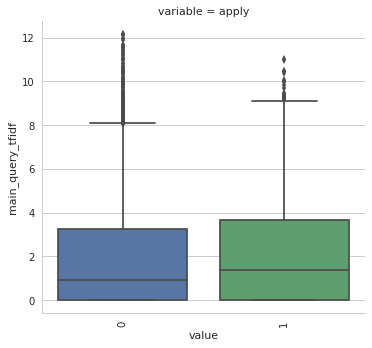

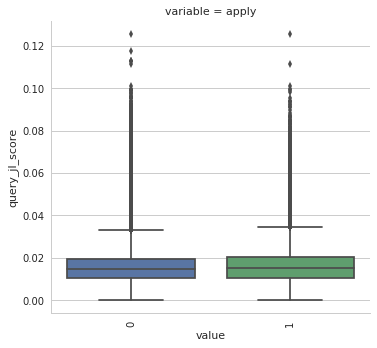

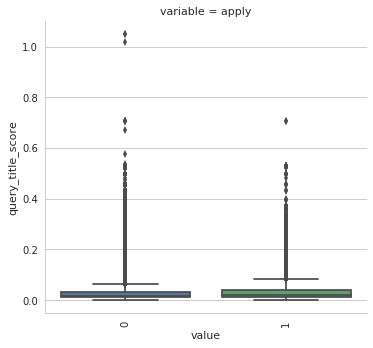

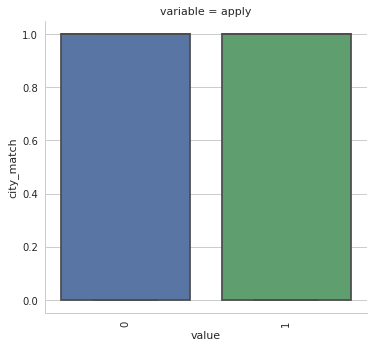

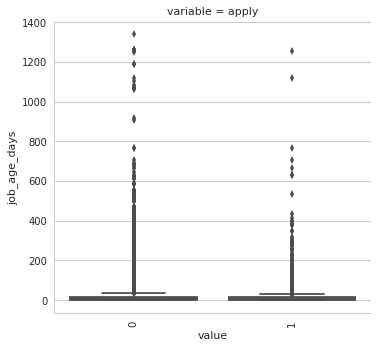

In [12]:
def boxplot(x,y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90);
    
features_numeric=[col for col in train_data.columns if col not in ['search_date_pacific','apply','class_id']]  

for col in features_numeric:
    feature_melted= pd.melt( train_data, id_vars=col, value_vars= target );
    train_Facet= sns.FacetGrid( feature_melted, col='variable',  col_wrap=2, sharex=False, sharey=False, size=5);
    train_plot= train_Facet.map( boxplot, 'value', col )
    
    
plt.show()


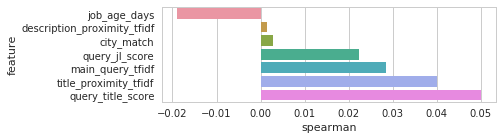

In [13]:
#Correlation Analysis
def spearman(frame, target, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame[target], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features) ) )
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    plt.show()
        

spearman( train_data, target, features_numeric );

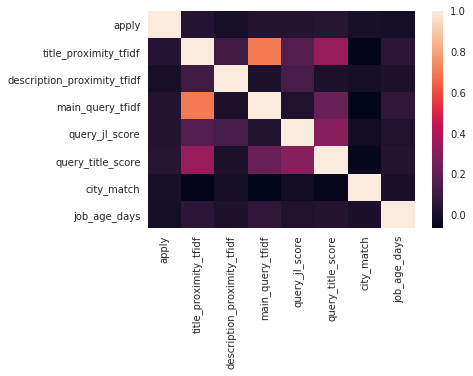

title_proximity_tfidf is highly correlated with query_title_score; query_title_score is highly correlated with the query_jl_score


In [14]:
corr = train_data[ [target]+ features_numeric ].corr()
sns.heatmap(corr)
plt.show()

print("title_proximity_tfidf is highly correlated with query_title_score; query_title_score is highly correlated with the query_jl_score");

In [15]:
#Method 1: use the first 7 numeric features (exclude the class_id categorical feature).
features_numeric=[col for col in train_data.columns if col not in ['search_date_pacific','apply','class_id']]
train_X=train_data.loc[:, features_numeric ];
train_y=train_data.loc[:, target];
test_X= test_data[ features_numeric ];
test_y= test_data[ target ];

In [16]:
#4. balance the two categories: y=0; y=1; We should drop the search_data_pacific.
from imblearn.over_sampling import SMOTE

os=SMOTE(random_state=0);
os_train_X, os_train_y= os.fit_sample(train_X, train_y);
os_train_X= pd.DataFrame( data= os_train_X, columns= train_X.columns );
os_train_y= pd.DataFrame( data= os_train_y, columns=[ target] );

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_train_X) )
print("Number of no apply in oversampled data", sum(os_train_y[target]==0) );
print("Number of apply",sum(os_train_y[target]==1) );
print("Proportion of no apply data in oversampled data is ",sum(os_train_y[target]==0)/len(os_train_X) )
print("Proportion of apply data in oversampled data is ",sum(os_train_y[target]==1)/len(os_train_X) )

length of oversampled data is  1179244
Number of no apply in oversampled data 589622
Number of apply 589622
Proportion of no apply data in oversampled data is  0.5
Proportion of apply data in oversampled data is  0.5


In [17]:
#Implementing the model
import statsmodels.api as sm
logit_model=sm.Logit( os_train_y, os_train_X)
result=logit_model.fit()
print(result.summary2() )

print("The p-value of all features are pretty small, keep all of them");

/home/xiaoling/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Optimization terminated successfully.
         Current function value: 0.689589
         Iterations 5
                               Results: Logit
Model:                 Logit               No. Iterations:      5.0000      
Dependent Variable:    apply               Pseudo R-squared:    0.005       
Date:                  2019-02-17 22:10    AIC:                 1626401.2733
No. Observations:      1179244             BIC:                 1626485.1360
Df Model:              6                   Log-Likelihood:      -8.1319e+05 
Df Residuals:          1179237             LL-Null:             -8.1739e+05 
Converged:             1.0000              Scale:               1.0000      
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
title_proximity_tfidf        0.0105   0.0003  34.3113 0.0000  0.0099  0.0111
descr

In [191]:
#Logistic Regression Model Fitting
#Divide the train dataset to be train and validate dataset so that we can evaluate models with the validate dataset
#to select the best model to predict the test dataset.
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
train_X_f, validate_X_f, train_y_f, validate_y_f = train_test_split(os_train_X,os_train_y, test_size=0.3, random_state=0)

logreg = LogisticRegression(solver='lbfgs' );
logreg.fit(train_X_f, train_y_f.values.ravel() );

In [192]:
validate_pred_y = logreg.predict(validate_X_f);
print('Accuracy of logistic regression classifier on validation set: {:.2f}'.format(logreg.score(validate_X_f, validate_y_f) ) );

Accuracy of logistic regression classifier on validation set: 0.54


In [169]:
from sklearn.metrics import classification_report
print(classification_report(validate_y_f, validate_pred_y))

              precision    recall  f1-score   support

           0       0.54      0.60      0.57    176838
           1       0.55      0.49      0.52    176936

   micro avg       0.54      0.54      0.54    353774
   macro avg       0.55      0.54      0.54    353774
weighted avg       0.55      0.54      0.54    353774



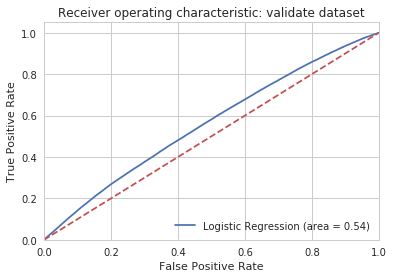

In [193]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(validate_y_f, logreg.predict(validate_X_f) )
fpr, tpr, thresholds = roc_curve(validate_y_f, logreg.predict_proba(validate_X_f)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: validate dataset')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [126]:
#Train the model with the whole dataset
logreg = LogisticRegression(solver='lbfgs' );
logreg.fit(os_train_X, os_train_y.values.ravel() );

/home/xiaoling/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [127]:
pred_y = logreg.predict(test_X);
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(test_X, test_y) ) );

Accuracy of logistic regression classifier on test set: 0.61


In [26]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(test_y, pred_y)
print(confusion_matrix)

[[37745 23147]
 [ 3177  2827]]


In [27]:
from sklearn.metrics import classification_report
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

           0       0.92      0.62      0.74     60892
           1       0.11      0.47      0.18      6004

   micro avg       0.61      0.61      0.61     66896
   macro avg       0.52      0.55      0.46     66896
weighted avg       0.85      0.61      0.69     66896



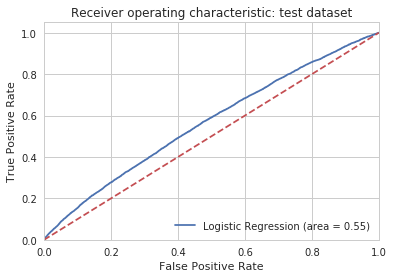

In [28]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(test_y, logreg.predict(test_X) )
fpr, tpr, thresholds = roc_curve(test_y, logreg.predict_proba(test_X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: test dataset')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

picked 7 features and eliminated the other 0 features


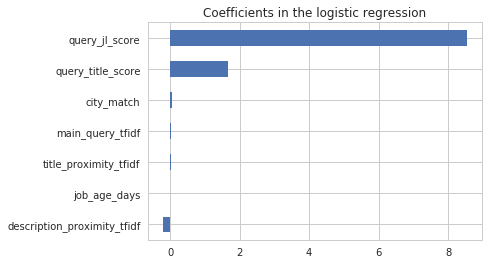

In [129]:
# Plot important coefficients
coefs = pd.Series( logreg.coef_.ravel(), index = os_train_X.columns.values)
print("picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = coefs.sort_values();
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the logistic regression")
plt.show()

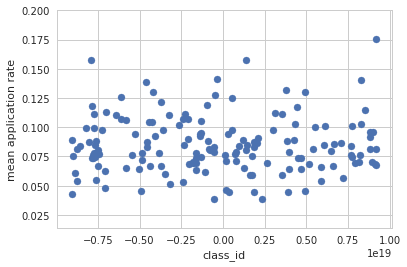

In [132]:
#Method2: Count in the class_in categorical feature. Convert the class_id to numeric data.
class_apply=train_data.groupby('class_id').mean();
class_apply= class_apply.sort_values(by='apply');
class_apply['apply_level']=np.arange(1, class_apply.shape[0]+1, 1);
id2apply= class_apply['apply_level'].to_dict();

plt.scatter( class_apply.index, class_apply['apply'] );
plt.xlabel('class_id');
plt.ylabel('mean application rate')
plt.show()


In [244]:
#Construct a dictionary which maps the id to the mean application rate
mean_application_rate= class_apply['apply'].mean()

In [47]:
train_X_id.head()

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,city_match,job_age_days,class_id,class_id
0,0.000000,0.000000,0.00000,0.004824,0.006628,0.0,5.0,15,15
1,11.874042,0.043637,2.52708,0.011935,0.011208,0.0,5.0,107,107
2,11.874042,0.043637,2.52708,0.011935,0.011208,0.0,5.0,107,107
22,0.000000,0.207074,0.00000,0.021350,0.021491,0.0,2.0,129,129
30,0.000000,0.000000,0.00000,0.014738,0.012877,0.0,12.0,31,31


In [134]:
#Replace the class_id in train_data and test_data with the mean_application_rate.
train_data_id= train_data.replace( { "class_id": id2apply} ); 
test_data_id= test_data.replace(  { "class_id": id2apply} );

In [135]:
features_numeric=[col for col in train_data.columns if col not in ['search_date_pacific','apply'] ]
train_X_id=train_data_id.loc[:, features_numeric ];
train_y_id=train_data_id.loc[:, target ];
test_X_id= test_data_id[ features_numeric ];
test_y_id= test_data_id[ target ];

In [136]:
#4. balance the two categories: y=0; y=1; We should drop the search_data_pacific.
from imblearn.over_sampling import SMOTE

os=SMOTE(random_state=0);
os_train_X_id, os_train_y_id= os.fit_sample(train_X_id, train_y_id);
os_train_X_id= pd.DataFrame( data= os_train_X_id, columns= train_X_id.columns );
os_train_y_id= pd.DataFrame( data= os_train_y_id, columns=[ target] );

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_train_X_id) )
print("Number of no apply in oversampled data", sum(os_train_y_id[target]==0) );
print("Number of apply",sum(os_train_y_id[target]==1) );
print("Proportion of no apply data in oversampled data is ",sum(os_train_y_id[target]==0)/len(os_train_X_id) )
print("Proportion of apply data in oversampled data is ",sum(os_train_y_id[target]==1)/len(os_train_X_id) )

length of oversampled data is  1179244
Number of no apply in oversampled data 589622
Number of apply 589622
Proportion of no apply data in oversampled data is  0.5
Proportion of apply data in oversampled data is  0.5


In [137]:
#Implementing the model
import statsmodels.api as sm
logit_model=sm.Logit( os_train_y_id, os_train_X_id)
result=logit_model.fit()
print(result.summary2() )

print("The p-value of all features are pretty small, keep all of them");

Optimization terminated successfully.
         Current function value: 0.687936
         Iterations 5
                               Results: Logit
Model:                 Logit               No. Iterations:      5.0000      
Dependent Variable:    apply               Pseudo R-squared:    0.008       
Date:                  2019-02-18 11:57    AIC:                 1622503.7782
No. Observations:      1179244             BIC:                 1622599.6213
Df Model:              7                   Log-Likelihood:      -8.1124e+05 
Df Residuals:          1179236             LL-Null:             -8.1739e+05 
Converged:             1.0000              Scale:               1.0000      
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
title_proximity_tfidf        0.0122   0.0003  39.2501 0.0000  0.0116  0.0128
descr

In [138]:
#Logistic Regression Model Fitting
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg_id = LogisticRegression(solver='lbfgs' );
logreg_id.fit(os_train_X_id, os_train_y_id.values.ravel() );

/home/xiaoling/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [140]:
pred_y_id = logreg_id.predict(test_X_id);
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg_id.score(test_X_id, test_y_id) ) );

Accuracy of logistic regression classifier on test set: 0.53


              precision    recall  f1-score   support

           0       0.93      0.52      0.67     60892
           1       0.11      0.59      0.18      6004

   micro avg       0.53      0.53      0.53     66896
   macro avg       0.52      0.56      0.43     66896
weighted avg       0.86      0.53      0.62     66896



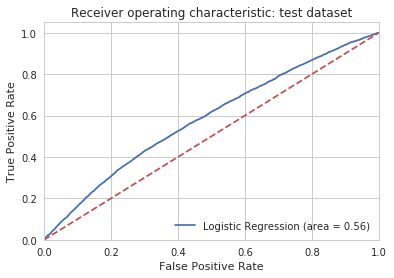

In [141]:
from sklearn.metrics import classification_report
print(classification_report(test_y_id, pred_y_id))

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(test_y_id, logreg_id.predict(test_X_id) )
fpr, tpr, thresholds = roc_curve(test_y_id, logreg_id.predict_proba(test_X_id)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: test dataset')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

picked 8 features and eliminated the other 0 features


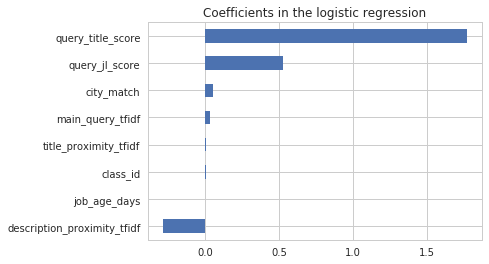

In [142]:
# Plot important coefficients
coefs = pd.Series( logreg_id.coef_.ravel(), index = os_train_X_id.columns.values)
print("picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = coefs.sort_values();
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the logistic regression")
plt.show()

In [101]:
#Method 3: get dummies for the 20 most fequent class_id; And keep the encoded class_id;
fre_id= train_data.groupby("class_id").apply(lambda x: len(x));
fre_id= fre_id.sort_values( ascending=False );
print(fre_id.head() )

class_id
 8530323770842619191    40630
-4246715430060585348    30750
-1614082818015232436    20767
-6998215076096305299    17701
-7731275881257460127    17156
dtype: int64


In [99]:

all_data= pd.concat( [train_data, test_data] );
fre_id= train_data.groupby("class_id").apply(lambda x: len(x));
fre_id= fre_id.sort_values( ascending=False );

for id in fre_id.index[0: 20]:
    all_data[ str(id) ]= all_data["class_id"].apply(lambda x: 1 if x==id else 0);

train_data_d= all_data.iloc[0: train_data.shape[0], :];
test_data_d= all_data.iloc[ train_data.shape[0]:, :];

features_numeric=[col for col in train_data_d.columns if col not in ["apply", "search_date_pacific" ] ];
train_X_d=train_data_d[ features_numeric];
train_y_d=train_data_d['apply'];
test_X_d= test_data_d[ features_numeric];
test_y_d= test_data_d['apply'];

#Replace the class_id in train_data and test_data with the mean_application_rate.
train_X_d= train_X_d.replace( { "class_id": id2apply} ); 
test_X_d= test_X_d.replace(  { "class_id": id2apply} );

In [108]:
# Balance the target feature.
#4. balance the two categories: y=0; y=1;
from imblearn.over_sampling import SMOTE

os=SMOTE(random_state=0);
os_train_X_d, os_train_y_d= os.fit_sample(train_X_d, train_y_d);
os_train_X_d= pd.DataFrame( data= os_train_X_d, columns= train_X_d.columns );
os_train_y_d= pd.DataFrame( data= os_train_y_d, columns=[ target] );

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_train_X_d) )
print("Number of no apply in oversampled data", sum(os_train_y_d[target]==0) );
print("Number of apply",sum(os_train_y_d[target]==1) );
print("Proportion of no apply data in oversampled data is ",sum(os_train_y_d[target]==0)/len(os_train_X_d) )
print("Proportion of apply data in oversampled data is ",sum(os_train_y_d[target]==1)/len(os_train_X_d) )


length of oversampled data is  1179244
Number of no apply in oversampled data 589622
Number of apply 589622
Proportion of no apply data in oversampled data is  0.5
Proportion of apply data in oversampled data is  0.5


In [114]:
#Implementing the model
import statsmodels.api as sm
logit_model=sm.Logit(os_train_y_d, os_train_X_d);
result=logit_model.fit()
print(result.summary2() )

#Remove these features if their p_value are too high;
remove=["4315422483091001102", "-3214316587352202517"];
features_removed=[col for col in os_train_X_d.columns if col not in remove];
os_train_X_d= os_train_X_d[features_removed];
test_X_d= test_X_d[features_removed];


Optimization terminated successfully.
         Current function value: 0.686830
         Iterations 5
                               Results: Logit
Model:                 Logit               No. Iterations:      5.0000      
Dependent Variable:    apply               Pseudo R-squared:    0.009       
Date:                  2019-02-18 11:15    AIC:                 1619936.3785
No. Observations:      1179244             BIC:                 1620271.8292
Df Model:              27                  Log-Likelihood:      -8.0994e+05 
Df Residuals:          1179216             LL-Null:             -8.1739e+05 
Converged:             1.0000              Scale:               1.0000      
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
title_proximity_tfidf        0.0108   0.0003  33.9500 0.0000  0.0101  0.0114
descr

In [116]:
os_train_X_d.shape

(1179244, 26)

/home/xiaoling/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Accuracy of logistic regression classifier on test set: 0.52
              precision    recall  f1-score   support

           0       0.93      0.52      0.66     60892
           1       0.11      0.60      0.18      6004

   micro avg       0.52      0.52      0.52     66896
   macro avg       0.52      0.56      0.42     66896
weighted avg       0.85      0.52      0.62     66896



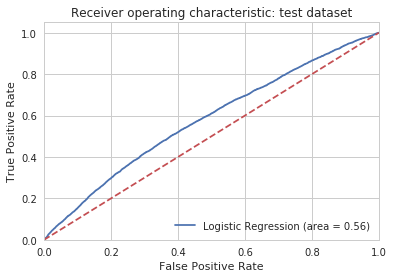

In [118]:
#Logistic Regression Model Fitting
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression(solver='lbfgs' );
logreg.fit(os_train_X_d, os_train_y_d.values.ravel() );

test_pred_d = logreg.predict(test_X_d)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(test_X_d, test_y_d)))

from sklearn.metrics import classification_report
print(classification_report(test_y_d, test_pred_d))

#Plot the AOC and visualize the AUC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(test_y_d, logreg.predict(test_X_d) )
fpr, tpr, thresholds = roc_curve(test_y_d, logreg.predict_proba(test_X_d)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: test dataset')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

picked 26 features and eliminated the other 0 features


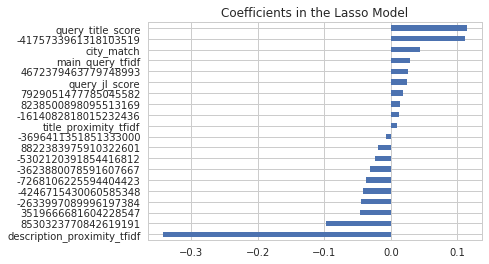

In [123]:
# Plot important coefficients
coefs = pd.Series( logreg.coef_.ravel(), index = os_train_X_d.columns.values)
print("picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()